In [1]:
import torch.nn
import os

from data.data_utils import GTZAN
from torch.utils.data import DataLoader
from training.inference import get_and_save_latents

def generate_evaluation_dataset(model, dataset_name, dataloader, name, chunking=True, averaging=False, chunk_size=256):
    model.mask_ratio = 0.0
    get_and_save_latents(dataloader, model, dataset_name, name, chunking=chunking, averaging=averaging, chunk_size=chunk_size)
    print("Saving...")

In [2]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import torch.nn
from torch import nn, optim

class MLP(nn.Module):
    def __init__(self, input=128, output=10, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(512, output)
        )

    def forward(self, x):
        return self.model(x)


class LinearProbe(nn.Module):
    def __init__(self, input=128, output=10):
        super().__init__()
        self.model = nn.Linear(input, output)

    def forward(self, x):
        return self.model(x)


# ----- Training Loop -----
def train_model(model, train_dataloader, test_dataloader, config, device="cuda", use_tqdm=False, criterion=nn.CrossEntropyLoss()):
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    model.train()
    best_accuracy = 0.0
    patience = 0

    itr = range(config.num_epochs)
    if use_tqdm:
        itr = tqdm(itr)

    for epoch in itr:
        total_loss = 0
        for labels, data in train_dataloader:
            # if dataset returns one-hot, convert back to integer for CrossEntropy
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)

            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scores, accuracy = evaluate_model(model, test_dataloader)

        if accuracy < best_accuracy:
            patience += 1
        else:
            patience = 0
            best_accuracy = accuracy

        if patience >= 32:
            return model

    return model


# Evaluation
def evaluate_model(model, dataloader, device="cuda", use_tqdm=False, criterion=nn.CrossEntropyLoss):
    model.eval()
    all_predictions = []
    all_labels = []

    itr = dataloader
    if use_tqdm:
        itr = tqdm(dataloader)

    for labels, data in dataloader:
        # if dataset returns one-hot, convert back to integer for CrossEntropy
        if labels.ndim > 1:
            labels = labels.argmax(dim=1)

        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)

        if criterion == nn.CrossEntropyLoss:
            predicted = outputs.argmax(dim=1).long()
        elif criterion == nn.BCEWithLogitsLoss:
            probability = torch.sigmoid(outputs)
            predicted = probability > 0.5

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    scores = f1_score(all_labels, all_predictions, average="macro")
    accuracy = accuracy_score(all_labels, all_predictions)

    return scores, accuracy

In [3]:
import numpy as np
import tqdm
import torch.nn
import os

from matplotlib import pyplot as plt
from training.evaluation import local_coherence
from data.data_utils import LatentDataset
from data.data_utils import GTZAN
from torch.utils.data import DataLoader
from utils.Config import Config
from data.data_utils import *
from training.inference import get_and_save_latents
from sklearn.metrics import auc

def local_tag_coherence(latent_dataset, max_k=100, granularity=1):
    latent_paths = latent_dataset.latents
    labels = latent_dataset.labels

    latents = []
    for path in tqdm(latent_paths):
        l = torch.load(path, weights_only=False)
        latents.append(l)

    l = torch.tensor(latents)

    if l.shape[1] == 1:
        l = l.squeeze(1)

    latents = np.array(l)

    tag_coherence = []
    k_values = []
    ks = [x for x in range(1, max_k, granularity)]
    for k in tqdm(ks):
        lgc = local_coherence(np.array(latents), np.array(labels), k=k)
        k_values.append(k)
        tag_coherence.append(lgc)

    auc_coh = auc(k_values, tag_coherence)

    print('computed AUC using sklearn.metrics.auc: {}'.format(auc_coh / k))
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, tag_coherence, label='Coherence')
    plt.xlabel("K-Neighbors")
    plt.ylabel("Coherence")
    plt.title("Coherence v.s. Neighboorhood Size")
    plt.legend()
    plt.grid(True)
    plt.show()


def grid_search(latent_dataset, num_classes=10, dataset="", criterion=nn.CrossEntropyLoss()):
    best_params = []
    best_accuracy = 0
    best_F1 = 0
    pb = tqdm(total=18)

    n_fold_length = len(latent_dataset)
    n_factor = int(n_fold_length / 10)
    random_indicies = np.random.permutation(n_fold_length)

    n_fold = random_indicies[:n_factor]
    other_folds = random_indicies[n_factor:]

    train_set = torch.utils.data.Subset(latent_dataset, other_folds)
    test_set = torch.utils.data.Subset(latent_dataset, n_fold)

    print("Training...")

    for model_type in ["MLP"]:
        for weight_decay in [0, 1e-4, 1e-3]:
            for learning_rate in [1e-5, 1e-4, 1e-3]:
                for batch in [64]: # Should be [64, 256]
                    for dropout in [0.25, 0.5] if model_type == "MLP" else [0]: # Should be [0.25, 0.5, 0.75]

                        model_name = f"LinearClassifier-{dataset}"
                        config = Config(
                                save_path=f"trained_models\\{model_name}\\",
                                num_epochs=1024,
                                learning_rate=learning_rate,
                                weight_decay=weight_decay,
                                num_workers=2,
                                batch_size= batch,
                                eval_batch_size=batch,
                                dtype=torch.float32
                            )


                        train_latent_dataloader = DataLoader(
                            train_set,
                            batch_size=64,
                            shuffle=True,
                        )

                        test_latent_dataloader = DataLoader(
                            test_set,
                            batch_size=64,
                            shuffle=True,
                        )

                        device = "cuda"

                        if model_type == "MLP":
                            model = MLP(128, num_classes, dropout=dropout).to(device)
                        else:
                            model = LinearProbe(128, num_classes).to(device)

                        train_model(model, train_latent_dataloader, test_latent_dataloader, config, device=device, use_tqdm=False, criterion=criterion)
                        f1, accuracy = evaluate_model(model, test_latent_dataloader, device, use_tqdm=False)

                        if accuracy > best_accuracy:
                            best_params = [model_type, learning_rate, weight_decay, dropout]
                            best_accuracy = accuracy
                            best_F1 = f1

                        pb.update(1)

    print(f"Best Accuracy: {best_accuracy}")
    print(f"Best F1: {best_F1}")

    return best_params

def continuous_fold(dataset, model_type, partition_name, learning_rate, weight_decay, dropout, batch_size, count=12):
    directory = f"D:\\SongsDataset\\GTZAN\\latent_datasets\\{partition_name}\\"

    num_classes = 10
    latent_dataset = LatentDataset(directory + "full-set\\", num_classes=num_classes)

    f1s = []
    accuracies = []

    for x in tqdm(range(count)):
        n_fold_length = len(latent_dataset)
        n_factor = int(n_fold_length / 10)

        random_indicies = np.random.permutation(n_fold_length)

        n_fold = random_indicies[:n_factor]
        other_folds = random_indicies[n_factor:]

        train_set = torch.utils.data.Subset(latent_dataset, other_folds)
        test_set = torch.utils.data.Subset(latent_dataset, n_fold)

        model_name = f"LinearClassifier-{dataset}"
        config = Config(
                save_path=f"trained_models\\{model_name}\\",
                num_epochs=1024,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                num_workers=2,
                batch_size= batch_size,
                eval_batch_size=batch_size,
                dtype=torch.float32
            )


        train_latent_dataloader = DataLoader(
            train_set,
            batch_size=64,
            shuffle=True,
        )

        test_latent_dataloader = DataLoader(
            test_set,
            batch_size=64,
            shuffle=True,
        )

        if model_type == "MLP":
            model = MLP(128, num_classes, dropout=dropout).to("cuda")
        else:
            model = LinearProbe(128, num_classes).to("cuda")

        device = "cuda"

        train_model(model, train_latent_dataloader, test_latent_dataloader, config, device=device, criterion=nn.CrossEntropyLoss())
        f1, accuracy = evaluate_model(model, test_latent_dataloader, device)
        f1s.append(f1)
        accuracies.append(accuracy)

    mean_f1 = sum(f1s) / len(f1s)
    variance_f1 = sum([(x - mean_f1) ** 2 for x in f1s]) / len(f1s)

    mean_accuracy = sum(accuracies) / len(accuracies)
    variance_accuracy = sum([(x - mean_accuracy) ** 2 for x in accuracies]) / len(accuracies)

    return (mean_f1, variance_f1), (mean_accuracy, variance_accuracy)

In [4]:
from data.data_utils import GTZAN
from torch.utils.data import DataLoader
import torch.nn

directory = "D:\\SongsDataset\\GTZAN\\genres_original\\"
GTZAN_dataset = GTZAN(directory)
GTZAN_dataloader = DataLoader(
    GTZAN_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    prefetch_factor=1
)

def gtzan_eval(model, name, chunking=True, chunk_size=256, averaging=True, k=100, already_generated=False, granularity=5):
    dataset_name = "GTZAN"
    if not already_generated:
        generate_evaluation_dataset(model, dataset_name, GTZAN_dataloader, name, chunking=chunking, chunk_size=chunk_size, averaging=averaging)

    num_classes = 10
    directory = f"D:\\SongsDataset\\GTZAN\\latent_datasets\\{name}\\"
    latent_dataset = LatentDataset(directory + "full-set\\", num_classes=num_classes)

    local_tag_coherence(latent_dataset, max_k=k, granularity=granularity)

    params = grid_search(latent_dataset, num_classes,  dataset=dataset_name, criterion=nn.CrossEntropyLoss())
    model_type, learning_rate, weight_decay, dropout = params
    batch_size = 64 if chunking else 1
    (mean_f1, variance_f1), (mean_accuracy, variance_accuracy) = continuous_fold(latent_dataset, model_type, name, learning_rate, weight_decay, dropout, batch_size, count=12)

    print(f"F1 | \nMean: {mean_f1}\t variance: {variance_f1}")
    print(f"Accuracy | \nMean: {mean_accuracy}\t variance: {variance_accuracy}")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
from torch.nn import BCEWithLogitsLoss
from data.data_utils import MTAT
from torch.utils.data import DataLoader
import torch.nn

directory = "D:\\SongsDataset\\MTAT\\"
MTAT_dataset = MTAT(directory)
MTAT_dataloader = DataLoader(
    MTAT_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    prefetch_factor=1
)

def mtat_eval(model, name, chunking=True, chunk_size=1024, averaging=True, k=100, already_generated=False, granularity=5):
    if not already_generated:
        generate_evaluation_dataset(model, "MTAT", MTAT_dataloader, name, chunking=chunking, chunk_size=chunk_size, averaging=averaging)

    num_classes = 10

    directory = f"D:\\SongsDataset\\MTAT\\latent_datasets\\{name}\\"
    latent_dataset = LatentDataset(directory + "full-set\\", num_classes=num_classes)

    local_tag_coherence(latent_dataset, max_k=k, granularity=granularity)

    params = grid_search(latent_dataset, num_classes, criterion=BCEWithLogitsLoss())
    model_type, learning_rate, weight_decay, dropout = params
    batch_size = 64 if chunking else 1
    (mean_f1, variance_f1), (mean_accuracy, variance_accuracy) = continuous_fold(latent_dataset, model_type, name, learning_rate, weight_decay, dropout, batch_size, count=12)

    print(f"F1 | \nMean: {mean_f1}\t variance: {variance_f1}")
    print(f"Accuracy | \nMean: {mean_accuracy}\t variance: {variance_accuracy}")

  0%|          | 0/25863 [00:00<?, ?it/s]

E:\Coding\SongAnalyzer\Analyzer\src\data\data_utils.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(full_path, sr=44100, mono=True)
E:\Coding\SongAnalyzer\.venv-flash\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



100%|██████████| 999/999 [01:11<00:00, 14.02it/s]


Saving...


  0%|          | 0/999 [00:00<?, ?it/s]

C:\Users\Potat\AppData\Local\Temp\ipykernel_7220\3693705025.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  latents = np.array(l)


  0%|          | 0/20 [00:00<?, ?it/s]

computed AUC using sklearn.metrics.auc: 0.47511521233939397


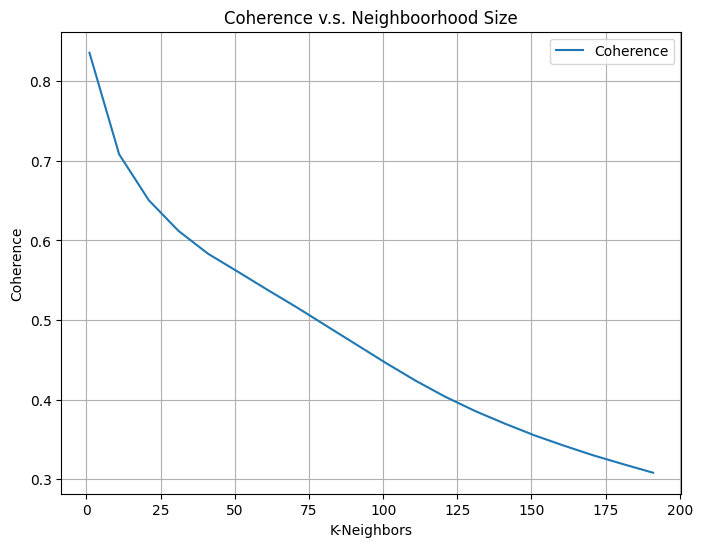

  0%|          | 0/18 [00:00<?, ?it/s]

Training...
Best Accuracy: 1.0
Best F1: 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

F1 | 
Mean: 1.0	 variance: 0.0
Accuracy | 
Mean: 1.0	 variance: 0.0




  0%|          | 0/25860 [00:00<?, ?it/s]

  0%|          | 1/25860 [00:11<80:01:56, 11.14s/it]

  0%|          | 5/25860 [00:11<12:06:31,  1.69s/it]

  0%|          | 9/25860 [00:11<5:35:02,  1.29it/s] 

  0%|          | 13/25860 [00:11<3:13:14,  2.23it/s]

  0%|          | 17/25860 [00:11<2:04:28,  3.46it/s]

  0%|          | 21/25860 [00:11<1:24:59,  5.07it/s]

  0%|          | 25/25860 [00:11<1:00:45,  7.09it/s]

  0%|          | 29/25860 [00:12<45:00,  9.57it/s]  

  0%|          | 33/25860 [00:12<35:32, 12.11it/s]

  0%|          | 37/25860 [00:12<29:01, 14.83it/s]

  0%|          | 41/25860 [00:12<24:39, 17.45it/s]

  0%|          | 45/25860 [00:12<22:16, 19.31it/s]

  0%|          | 48/25860 [00:12<20:36, 20.88it/s]

  0%|          | 51/25860 [00:12<19:11, 22.41it/s]

  0%|          | 55/25860 [00:12<17:38, 24.38it/s]

  0%|          | 59/25860 [00:13<16:29, 26.07it/s]

  0%|          | 63/25860 [00:13<15:41, 27.39it/s]

  0%|          | 67/25860 [00:13<14:59, 28.67it/s]

  0

Saving...


  0%|          | 0/25860 [00:00<?, ?it/s]

C:\Users\Potat\AppData\Local\Temp\ipykernel_7220\3693705025.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  latents = np.array(l)


  0%|          | 0/4 [00:00<?, ?it/s]

computed AUC using sklearn.metrics.auc: 0.9136777420097894


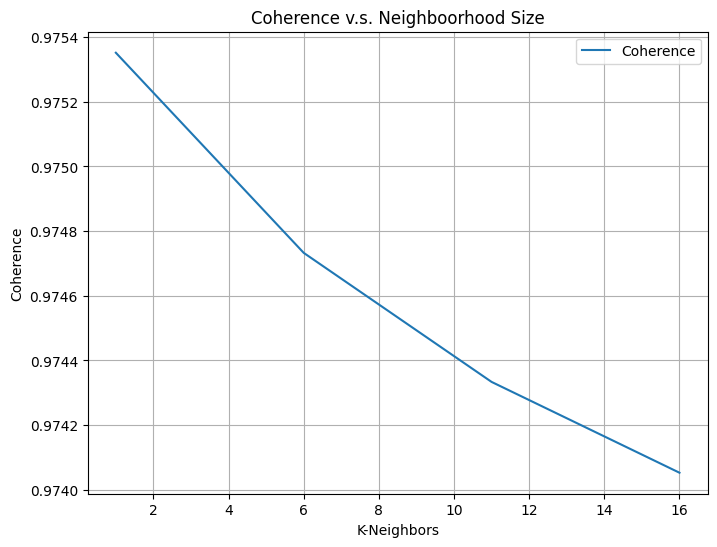

  0%|          | 0/18 [00:00<?, ?it/s]

Training...


AttributeError: 'list' object has no attribute 'ndim'

In [9]:
model = torch.load("E:\\Coding\\SongAnalyzer\\Analyzer\\src\\final-models\\Myna-sinusoidal-ALIBI-256L-0.9M\\sinusoidal_Epoch-511.pt", weights_only=False)
model.mask_ratio = 0
name = "Sinusoidal-Chunking-256"
gtzan_eval(model, name, chunking=True, chunk_size=256, averaging=True, k=200, already_generated=False, granularity=10)
mtat_eval(model, name, chunking=True, chunk_size=256, averaging=True, k=20, already_generated=False, granularity=5)


In [ ]:
model = torch.load("E:\\Coding\\SongAnalyzer\\Analyzer\\src\\final-models\\Myna-1D-ALIBI-256L-0.9M\\1d_alibi_Epoch-511.pt", weights_only=False)
model.mask_ratio = 0
name = "1D-ALIBI-Chunking-256"
gtzan_eval(model, name, chunking=True, chunk_size=256, averaging=True, k=200, already_generated=False, granularity=10)
mtat_eval(model, name, chunking=True, chunk_size=256, averaging=True, k=20, already_generated=False, granularity=5)

  0%|          | 0/999 [00:00<?, ?it/s]E:\Coding\SongAnalyzer\Analyzer\src\training\inference.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)
100%|██████████| 999/999 [00:54<00:00, 18.34it/s]


Saving...


  0%|          | 0/999 [00:00<?, ?it/s]

C:\Users\Potat\AppData\Local\Temp\ipykernel_7220\3693705025.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  l = torch.tensor(latents)
C:\Users\Potat\AppData\Local\Temp\ipykernel_7220\3693705025.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  latents = np.array(l)


  0%|          | 0/20 [00:00<?, ?it/s]

computed AUC using sklearn.metrics.auc: 0.47005839789640136


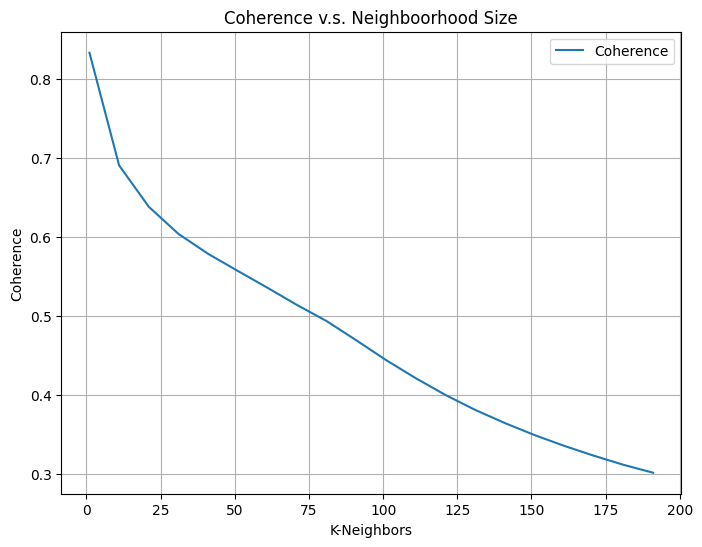

  0%|          | 0/18 [00:00<?, ?it/s]

Training...
Best Accuracy: 1.0
Best F1: 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

F1 | 
Mean: 1.0	 variance: 0.0
Accuracy | 
Mean: 1.0	 variance: 0.0


  0%|          | 0/25860 [00:00<?, ?it/s]E:\Coding\SongAnalyzer\Analyzer\src\training\inference.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)
100%|██████████| 25860/25860 [23:47<00:00, 18.12it/s]


Saving...


  0%|          | 0/25860 [00:00<?, ?it/s]

C:\Users\Potat\AppData\Local\Temp\ipykernel_7220\3693705025.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  latents = np.array(l)


  0%|          | 0/4 [00:00<?, ?it/s]

computed AUC using sklearn.metrics.auc: 0.9134745339347097


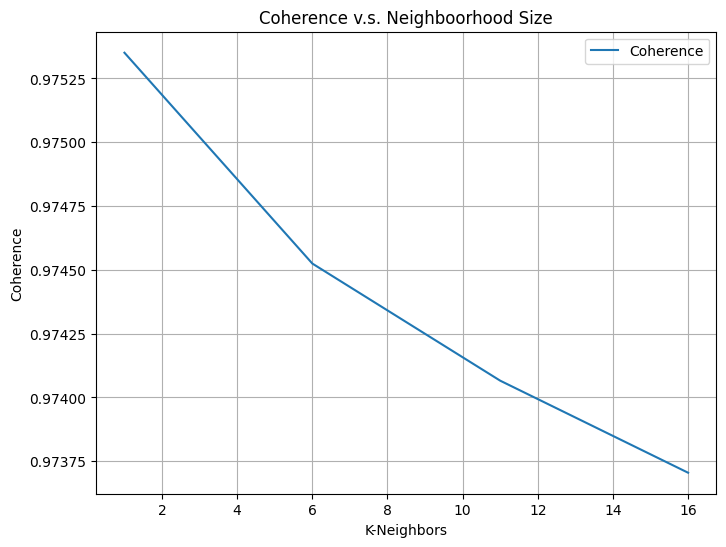

  0%|          | 0/18 [00:00<?, ?it/s]

Training...


AttributeError: 'list' object has no attribute 'ndim'

In [6]:
model = torch.load("E:\\Coding\\SongAnalyzer\\Analyzer\\src\\final-models\\Myna-1D-ALIBI-256L-0.9M\\1d_alibi_Epoch-511.pt", weights_only=False)
model.mask_ratio = 0
name = "1D-ALIBI-No-Chunking"
gtzan_eval(model, name, chunking=False, chunk_size=256, averaging=True, k=200, already_generated=False, granularity=10)
mtat_eval(model, name, chunking=False, chunk_size=256, averaging=True, k=20, already_generated=False, granularity=5)

In [ ]:
model = torch.load("E:\\Coding\\SongAnalyzer\\Analyzer\\src\\final-models\\Myna-2D-ALIBI-ALIBI-256L-0.9M\\2d_alibi_Epoch-511.pt", weights_only=False)
model.mask_ratio = 0
name = "2D-ALIBI-Chunking-256"
gtzan_eval(model, name, chunking=True, chunk_size=256, averaging=True, k=100, already_generated=False, granularity=5)
mtat_eval(model, name, chunking=True, chunk_size=256, averaging=True, k=30, already_generated=False, granularity=10)